<a href="https://colab.research.google.com/github/thiensean/Grounded-Segment-Anything/blob/main/api_groundedsam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
%cd /content

!git clone https://github.com/IDEA-Research/Grounded-Segment-Anything

%cd /content/Grounded-Segment-Anything
!pip install -q -r requirements.txt
%cd /content/Grounded-Segment-Anything/GroundingDINO
!pip install -q .
%cd /content/Grounded-Segment-Anything/segment_anything
!pip install -q .
%cd /content/Grounded-Segment-Anything
!pip install accelerate

/content
fatal: destination path 'Grounded-Segment-Anything' already exists and is not an empty directory.
/content/Grounded-Segment-Anything
/content/Grounded-Segment-Anything/GroundingDINO
  Preparing metadata (setup.py) ... done
/content/Grounded-Segment-Anything/segment_anything
  Preparing metadata (setup.py) ... done
/content/Grounded-Segment-Anything


In [18]:
!pip install fastapi
!pip install accelerate
!pip install uvicorn[standard]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.4/341.4 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 92.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.9 MB/s eta 0:00:00


In [25]:
from IPython import get_ipython
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip
get_ipython().system_raw('python3 app.py &')
get_ipython().system_raw('./ngrok http 5000 &')

--2023-10-30 12:33:02--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 18.205.222.128, 54.161.241.46, 52.202.168.65, ...
Connecting to bin.equinox.io (bin.equinox.io)|18.205.222.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13921656 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.2’

ngrok-stable-linux- 100%[===================>]  13.28M  5.49MB/s    in 2.4s    

2023-10-30 12:33:05 (5.49 MB/s) - ‘ngrok-stable-linux-amd64.zip.2’ saved [13921656/13921656]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [26]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://b78e-34-142-236-249.ngrok.io


In [27]:
import fastapi
from pydantic import BaseModel
import joblib
import uvicorn

import os, sys

sys.path.append(os.path.join(os.getcwd(), "GroundingDINO"))

import argparse
import copy

from IPython.display import display

import requests
import torch
from io import BytesIO


app = fastapi.FastAPI()

class InputData(BaseModel):
    feature1: float

@app.post("/predict/")
async def predict(data: InputData):

  result = 10

  prediction = result
  return {"prediction": prediction}

uvicorn.run("app.app:app",host='127.0.0.1', port=5000, reload=True, workers=3)

# if __name__ == "__main__":
#   uvicorn.run(app, host="127.0.0.1", port=5000)

INFO:     Will watch for changes in these directories: ['/content/Grounded-Segment-Anything']
INFO:     Uvicorn running on http://localhost:5000 (Press CTRL+C to quit)
INFO:     Started reloader process [292] using StatReload
INFO:     Stopping reloader process [292]


In [28]:
import fastapi
from pydantic import BaseModel
import joblib
import uvicorn

import os, sys

sys.path.append(os.path.join(os.getcwd(), "GroundingDINO"))

import argparse
import copy

from IPython.display import display
from PIL import Image, ImageDraw, ImageFont
from torchvision.ops import box_convert

# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from GroundingDINO.groundingdino.util.inference import annotate, load_image, predict

import supervision as sv

# segment anything
from segment_anything import build_sam, SamPredictor
import cv2
import numpy as np
import matplotlib.pyplot as plt


# diffusers
import PIL
import requests
import torch
from io import BytesIO
from diffusers import StableDiffusionInpaintPipeline


from huggingface_hub import hf_hub_download

app = fastapi.FastAPI()

class InputData(BaseModel):
    feature1: float

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file)
    args.device = device
    model = build_model(args)

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location=device)
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model

ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"


groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename, device)

sam_checkpoint = '/content/drive/MyDrive/siamese/SegmentAnything/sam_vit_h_4b8939.pth'

sam_predictor = SamPredictor(build_sam(checkpoint=sam_checkpoint).to(device))

sd_pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
).to(device)

# Load image
def download_image(url, image_file_path):
    r = requests.get(url, timeout=4.0)
    if r.status_code != requests.codes.ok:
        assert False, 'Status code error: {}.'.format(r.status_code)

    with Image.open(BytesIO(r.content)) as im:
        im.save(image_file_path)
    print('Image downloaded from url: {} and saved to: {}.'.format(url, image_file_path))


local_image_path = "assets/inpaint_demo.png"
# image_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
image_url = "https://raw.githubusercontent.com/ts-potofgold/segmentanything/main/s-l1200.png"

download_image(image_url, local_image_path)
image_source, image = load_image(local_image_path)
# Image.fromarray(image_source)

# detect object using grounding DINO
def detect(image, text_prompt, model, box_threshold = 0.3, text_threshold = 0.25):
  boxes, logits, phrases = predict(
      model=model,
      image=image,
      caption=text_prompt,
      box_threshold=box_threshold,
      text_threshold=text_threshold
  )

  annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
  annotated_frame = annotated_frame[...,::-1] # BGR to RGB
  return annotated_frame, boxes

def segment(image, sam_model, boxes):
  sam_model.set_image(image)
  H, W, _ = image.shape
  boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

  transformed_boxes = sam_model.transform.apply_boxes_torch(boxes_xyxy.to(device), image.shape[:2])
  masks, _, _ = sam_model.predict_torch(
      point_coords = None,
      point_labels = None,
      boxes = transformed_boxes,
      multimask_output = False,
      )
  return masks.cpu()


def draw_mask(mask, image, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

def generate_image(image, mask, prompt, negative_prompt, pipe, seed):
  # resize for inpainting
  w, h = image.size
  in_image = image.resize((5120, 5120))
  in_mask = mask.resize((5120, 5120))

  generator = torch.Generator(device).manual_seed(seed)

  global result
  result = pipe(image=in_image, mask_image=in_mask, prompt=prompt, negative_prompt=negative_prompt, generator=generator)
  result = result.images[0]

  return result.resize((w, h))


@app.post("/predict/")
async def predict(data: InputData):

  annotated_frame, detected_boxes = detect(image, text_prompt="swimwear", model=groundingdino_model)
  segmented_frame_masks = segment(image_source, sam_predictor, boxes=detected_boxes)
  annotated_frame_with_mask = draw_mask(segmented_frame_masks[0][0], annotated_frame)

  # create mask images
  mask = segmented_frame_masks[0][0].cpu().numpy()
  inverted_mask = ((1 - mask) * 255).astype(np.uint8)


  image_source_pil = Image.fromarray(image_source)
  image_mask_pil = Image.fromarray(mask)
  inverted_image_mask_pil = Image.fromarray(inverted_mask)

  prompt="in ancient egypt, royal cat from ancient egypt"
  negative_prompt="low resolution, ugly"
  # seed = 32 # for reproducibility

  generated_image = generate_image(image_source_pil, inverted_image_mask_pil, prompt, negative_prompt, sd_pipe, seed)
  result

  prediction = result
  return {"prediction": prediction}

uvicorn.run("app.app:app",host='127.0.0.1', port=5000, reload=True, workers=3)

# if __name__ == "__main__":
#   uvicorn.run(app, host="127.0.0.1", port=5000)


Exception ignored in: <coroutine object Server.serve at 0x7d3052df5ee0>
Traceback (most recent call last):
  File "<string>", line 1, in <lambda>
KeyError: '__import__'
Exception ignored in: <coroutine object Server.serve at 0x7d3052df5ee0>
Traceback (most recent call last):
  File "<string>", line 1, in <lambda>
KeyError: '__import__'
Exception ignored in: <coroutine object Server.serve at 0x7d3052df43c0>
Traceback (most recent call last):
  File "<string>", line 1, in <lambda>
KeyError: '__import__'
Exception ignored in: <coroutine object Server.serve at 0x7d306fa3cba0>
Traceback (most recent call last):
  File "<string>", line 1, in <lambda>
KeyError: '__import__'


final text_encoder_type: bert-base-uncased
Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Image downloaded from url: https://raw.githubusercontent.com/ts-potofgold/segmentanything/main/s-l1200.png and saved to: assets/inpaint_demo.png.


INFO:     Will watch for changes in these directories: ['/content/Grounded-Segment-Anything']
INFO:     Uvicorn running on http://127.0.0.1:5000 (Press CTRL+C to quit)
INFO:     Started reloader process [292] using StatReload
INFO:     Stopping reloader process [292]


## API Development

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content

!git clone https://github.com/IDEA-Research/Grounded-Segment-Anything

%cd /content/Grounded-Segment-Anything
!pip install -q -r requirements.txt
%cd /content/Grounded-Segment-Anything/GroundingDINO
!pip install -q .
%cd /content/Grounded-Segment-Anything/segment_anything
!pip install -q .
%cd /content/Grounded-Segment-Anything

/content
Cloning into 'Grounded-Segment-Anything'...
remote: Enumerating objects: 1619, done.
remote: Counting objects: 100% (522/522), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 1619 (delta 454), reused 396 (delta 388), pack-reused 1097
Receiving objects: 100% (1619/1619), 124.74 MiB | 38.85 MiB/s, done.
Resolving deltas: 100% (746/746), done.
/content/Grounded-Segment-Anything
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 66.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [31]:
import os, sys

sys.path.append(os.path.join(os.getcwd(), "GroundingDINO"))

import argparse
import copy

from IPython.display import display
from PIL import Image, ImageDraw, ImageFont
from torchvision.ops import box_convert

# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from GroundingDINO.groundingdino.util.inference import annotate, load_image, predict

import supervision as sv

# segment anything
from segment_anything import build_sam, SamPredictor
import cv2
import numpy as np
import matplotlib.pyplot as plt


# diffusers
import PIL
import requests
import torch
from io import BytesIO
from diffusers import StableDiffusionInpaintPipeline


from huggingface_hub import hf_hub_download

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [33]:
def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file)
    args.device = device
    model = build_model(args)

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location=device)
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model

In [34]:
ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"


groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename, device)

final text_encoder_type: bert-base-uncased
Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


In [35]:
! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

sam_checkpoint = 'sam_vit_h_4b8939.pth'

sam_predictor = SamPredictor(build_sam(checkpoint=sam_checkpoint).to(device))

--2023-10-30 13:10:48--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 52.84.251.106, 52.84.251.15, 52.84.251.27, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|52.84.251.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  47.0MB/s    in 54s     

2023-10-30 13:11:42 (45.3 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [36]:
sd_pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
).to(device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:479: RuntimeWarning: coroutine 'Server.serve' was never awaited
  super().__setattr__('_is_full_backward_hook', None)


Image downloaded from url: https://raw.githubusercontent.com/ts-potofgold/segmentanything/main/s-l1600.jpg and saved to: assets/inpaint_demo.png.


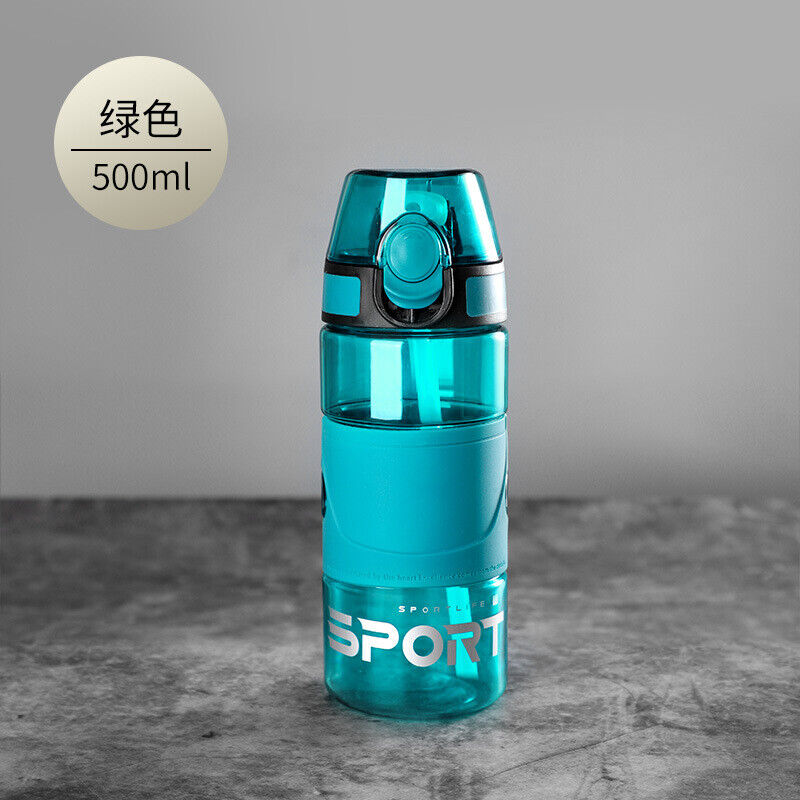

In [53]:
# Load image
def download_image(url, image_file_path):
    r = requests.get(url, timeout=4.0)
    if r.status_code != requests.codes.ok:
        assert False, 'Status code error: {}.'.format(r.status_code)

    with Image.open(BytesIO(r.content)) as im:
        im.save(image_file_path)
    print('Image downloaded from url: {} and saved to: {}.'.format(url, image_file_path))


local_image_path = "assets/inpaint_demo.png"
# image_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
# image_url = "https://raw.githubusercontent.com/ts-potofgold/segmentanything/main/s-l1200.png" ## Swimsuit
image_url = "https://raw.githubusercontent.com/ts-potofgold/segmentanything/main/s-l1600.jpg"

download_image(image_url, local_image_path)
image_source, image = load_image(local_image_path)
Image.fromarray(image_source)

In [54]:
# detect object using grounding DINO
def detect(image, text_prompt, model, box_threshold = 0.3, text_threshold = 0.25):
  boxes, logits, phrases = predict(
      model=model,
      image=image,
      caption=text_prompt,
      box_threshold=box_threshold,
      text_threshold=text_threshold
  )

  annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
  annotated_frame = annotated_frame[...,::-1] # BGR to RGB
  return annotated_frame, boxes

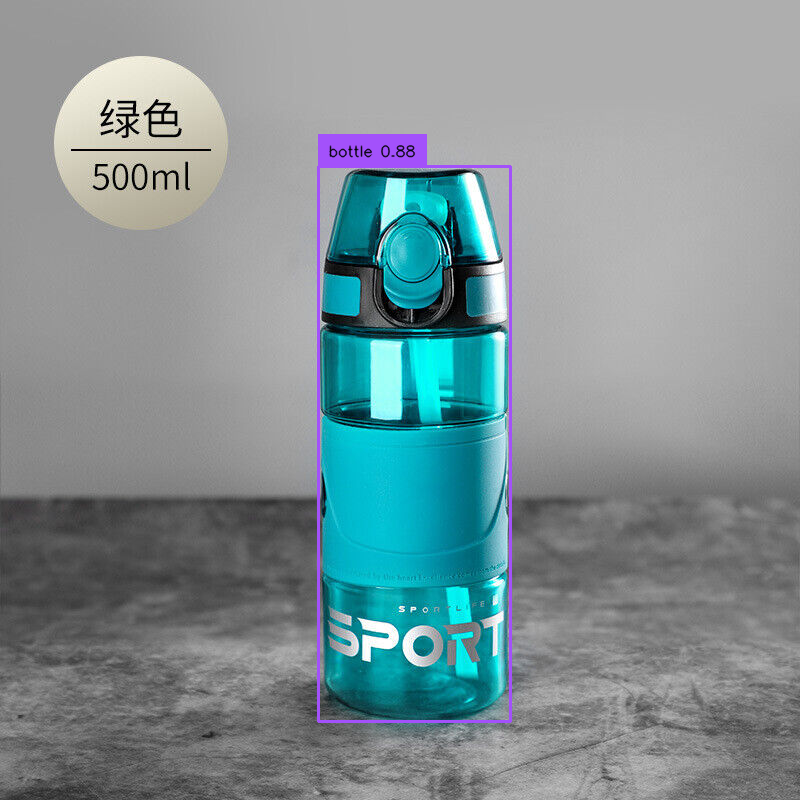

In [55]:
annotated_frame, detected_boxes = detect(image, text_prompt="bottle", model=groundingdino_model)
Image.fromarray(annotated_frame)

In [56]:
def segment(image, sam_model, boxes):
  sam_model.set_image(image)
  H, W, _ = image.shape
  boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

  transformed_boxes = sam_model.transform.apply_boxes_torch(boxes_xyxy.to(device), image.shape[:2])
  masks, _, _ = sam_model.predict_torch(
      point_coords = None,
      point_labels = None,
      boxes = transformed_boxes,
      multimask_output = False,
      )
  return masks.cpu()


def draw_mask(mask, image, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

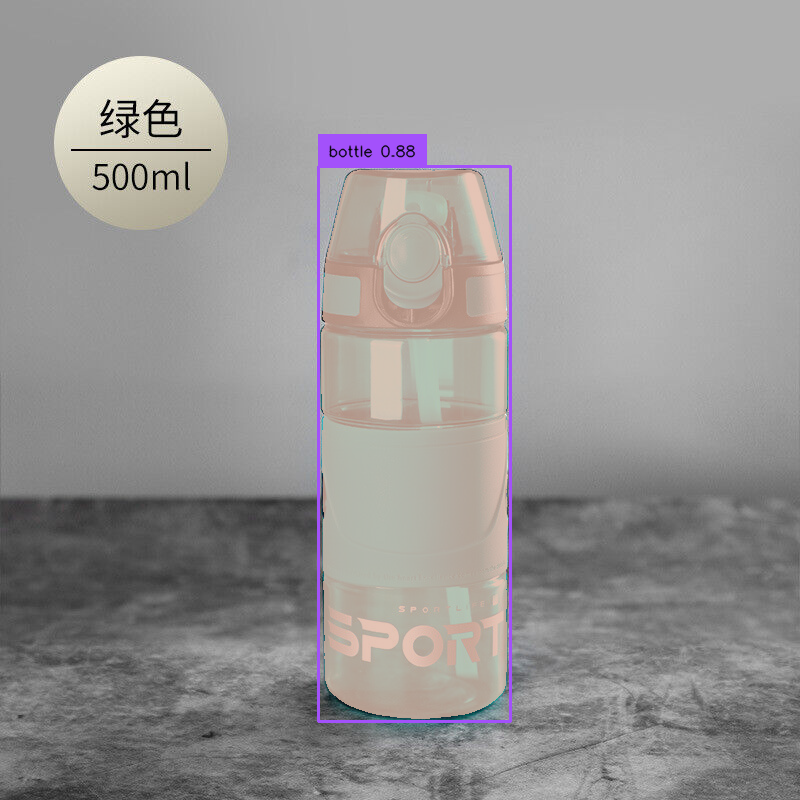

In [57]:
segmented_frame_masks = segment(image_source, sam_predictor, boxes=detected_boxes)
annotated_frame_with_mask = draw_mask(segmented_frame_masks[0][0], annotated_frame)
Image.fromarray(annotated_frame_with_mask)

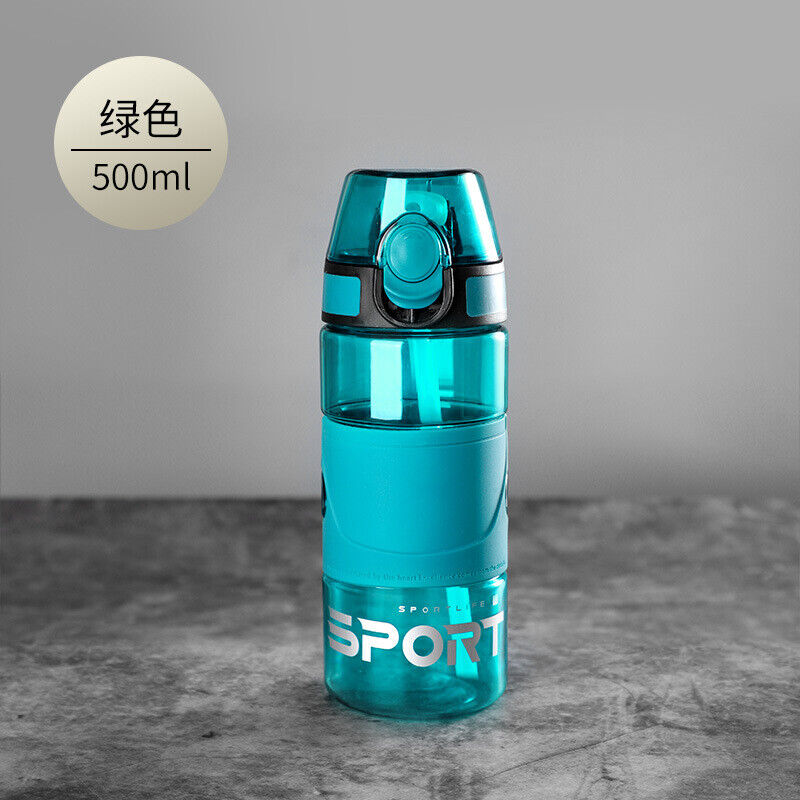

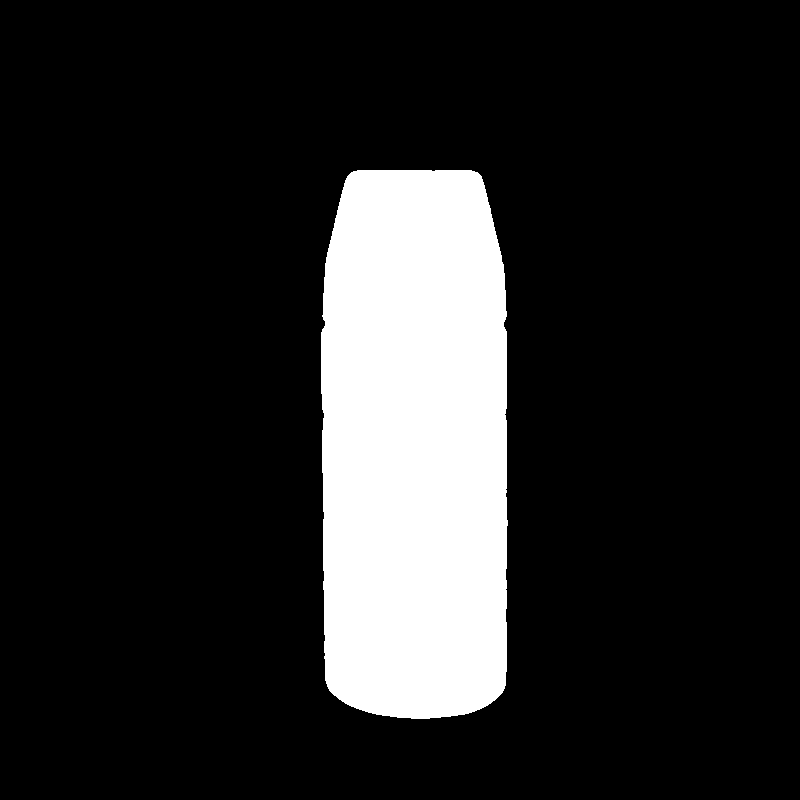

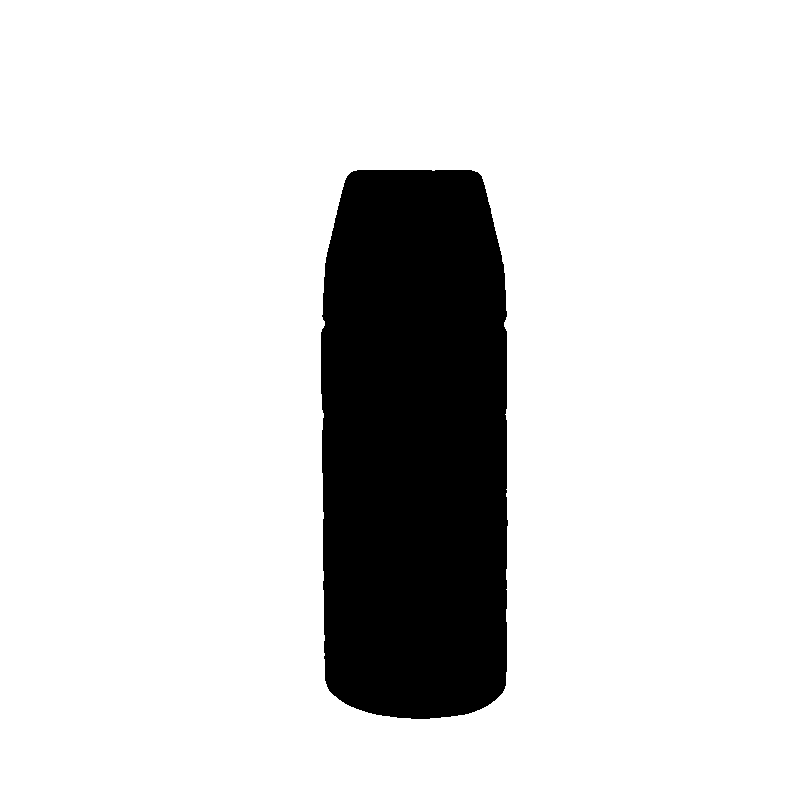

In [58]:
# create mask images
mask = segmented_frame_masks[0][0].cpu().numpy()
inverted_mask = ((1 - mask) * 255).astype(np.uint8)


image_source_pil = Image.fromarray(image_source)
image_mask_pil = Image.fromarray(mask)
inverted_image_mask_pil = Image.fromarray(inverted_mask)


display(*[image_source_pil, image_mask_pil, inverted_image_mask_pil])

In [59]:
def generate_image(image, mask, prompt, negative_prompt, pipe, seed):
  # resize for inpainting
  w, h = image.size
  in_image = image.resize((5120, 5120))
  in_mask = mask.resize((5120, 5120))

  generator = torch.Generator(device).manual_seed(seed)

  global result
  result = pipe(image=in_image, mask_image=in_mask, prompt=prompt, negative_prompt=negative_prompt, generator=generator)
  result = result.images[0]

  return result.resize((w, h))

  0%|          | 0/50 [00:00<?, ?it/s]

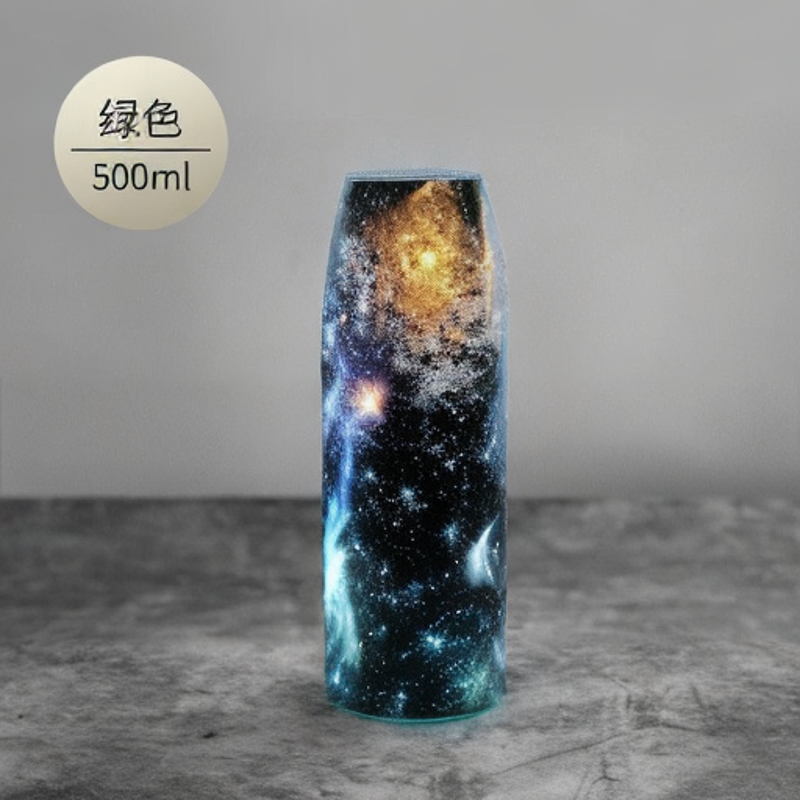

In [62]:
prompt="outer space, galaxy, high resolution, detailed"
negative_prompt="low resolution, ugly, words"
# seed = 32 # for reproducibility

generated_image = generate_image(image=image_source_pil, mask=image_mask_pil, prompt=prompt, negative_prompt=negative_prompt, pipe=sd_pipe, seed=seed)
generated_image

  0%|          | 0/50 [00:00<?, ?it/s]

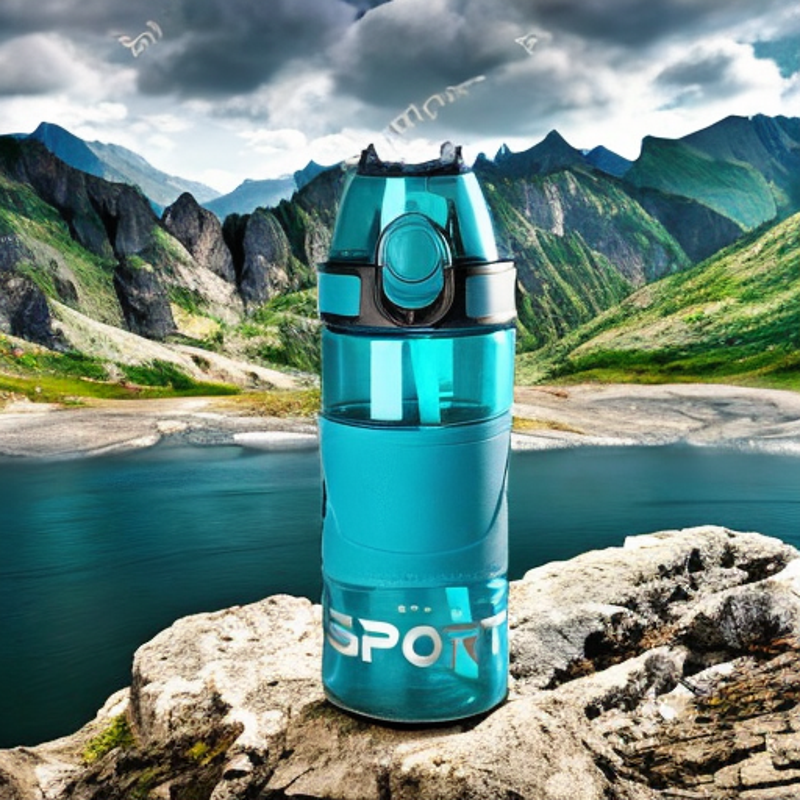

In [74]:
prompt="unreal mountains, high resolution, marketing photo"
negative_prompt="low resolution, ugly"
seed = 32 # for reproducibility

generated_image = generate_image(image_source_pil, inverted_image_mask_pil, prompt, negative_prompt, sd_pipe, seed)
generated_image

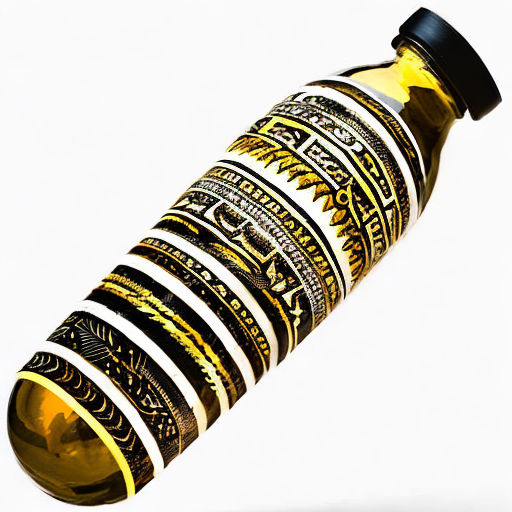

In [45]:
result

## Install

In [1]:
%cd /content

!git clone https://github.com/IDEA-Research/Grounded-Segment-Anything

%cd /content/Grounded-Segment-Anything
!pip install -q -r requirements.txt
%cd /content/Grounded-Segment-Anything/GroundingDINO
!pip install -q .
%cd /content/Grounded-Segment-Anything/segment_anything
!pip install -q .
%cd /content/Grounded-Segment-Anything

/content
Cloning into 'Grounded-Segment-Anything'...
remote: Enumerating objects: 1619, done.
remote: Counting objects: 100% (293/293), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 1619 (delta 240), reused 226 (delta 218), pack-reused 1326
Receiving objects: 100% (1619/1619), 124.72 MiB | 33.42 MiB/s, done.
Resolving deltas: 100% (745/745), done.
/content/Grounded-Segment-Anything
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 78.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 76.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 85.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Imports

In [2]:
import os, sys

sys.path.append(os.path.join(os.getcwd(), "GroundingDINO"))

import argparse
import copy

from IPython.display import display
from PIL import Image, ImageDraw, ImageFont
from torchvision.ops import box_convert

# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from GroundingDINO.groundingdino.util.inference import annotate, load_image, predict

import supervision as sv

# segment anything
from segment_anything import build_sam, SamPredictor
import cv2
import numpy as np
import matplotlib.pyplot as plt


# diffusers
import PIL
import requests
import torch
from io import BytesIO
from diffusers import StableDiffusionInpaintPipeline


from huggingface_hub import hf_hub_download

## Load models

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Grounding DINO model

In [4]:
def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file)
    args.device = device
    model = build_model(args)

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location=device)
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model

In [5]:
ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"


groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename, device)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


### SAM

In [6]:
! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

sam_checkpoint = 'sam_vit_h_4b8939.pth'

sam_predictor = SamPredictor(build_sam(checkpoint=sam_checkpoint).to(device))

--2023-10-29 10:53:27--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.155.173.116, 18.155.173.79, 18.155.173.40, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.155.173.116|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  58.7MB/s    in 26s     

2023-10-29 10:53:53 (93.7 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



### Stable Diffusion (Inpainting)

In [7]:
sd_pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
).to(device)

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

## Inference

Image downloaded from url: https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png and saved to: assets/inpaint_demo.jpg.


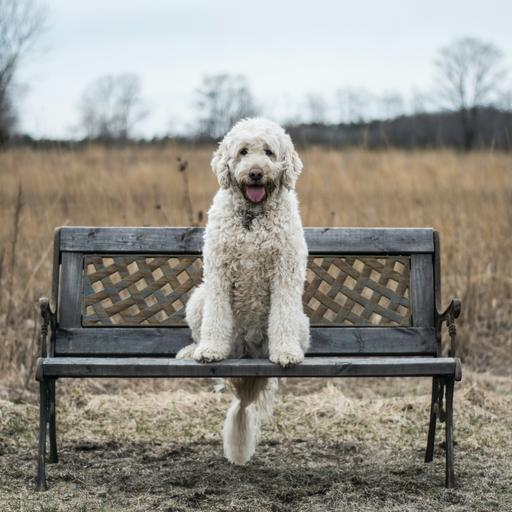

In [8]:
# Load image
def download_image(url, image_file_path):
    r = requests.get(url, timeout=4.0)
    if r.status_code != requests.codes.ok:
        assert False, 'Status code error: {}.'.format(r.status_code)

    with Image.open(BytesIO(r.content)) as im:
        im.save(image_file_path)
    print('Image downloaded from url: {} and saved to: {}.'.format(url, image_file_path))


local_image_path = "assets/inpaint_demo.jpg"
image_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"

download_image(image_url, local_image_path)
image_source, image = load_image(local_image_path)
Image.fromarray(image_source)

## Grounding DINO for detection

In [9]:
# detect object using grounding DINO
def detect(image, text_prompt, model, box_threshold = 0.3, text_threshold = 0.25):
  boxes, logits, phrases = predict(
      model=model,
      image=image,
      caption=text_prompt,
      box_threshold=box_threshold,
      text_threshold=text_threshold
  )

  annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
  annotated_frame = annotated_frame[...,::-1] # BGR to RGB
  return annotated_frame, boxes

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:905: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


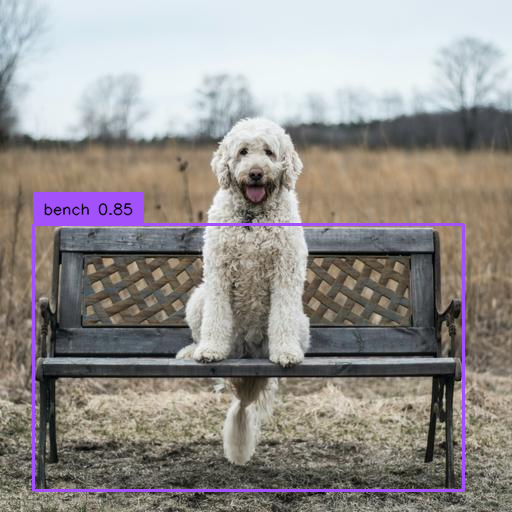

In [10]:
annotated_frame, detected_boxes = detect(image, text_prompt="bench", model=groundingdino_model)
Image.fromarray(annotated_frame)

## SAM for segmentation

In [11]:
def segment(image, sam_model, boxes):
  sam_model.set_image(image)
  H, W, _ = image.shape
  boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

  transformed_boxes = sam_model.transform.apply_boxes_torch(boxes_xyxy.to(device), image.shape[:2])
  masks, _, _ = sam_model.predict_torch(
      point_coords = None,
      point_labels = None,
      boxes = transformed_boxes,
      multimask_output = False,
      )
  return masks.cpu()


def draw_mask(mask, image, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

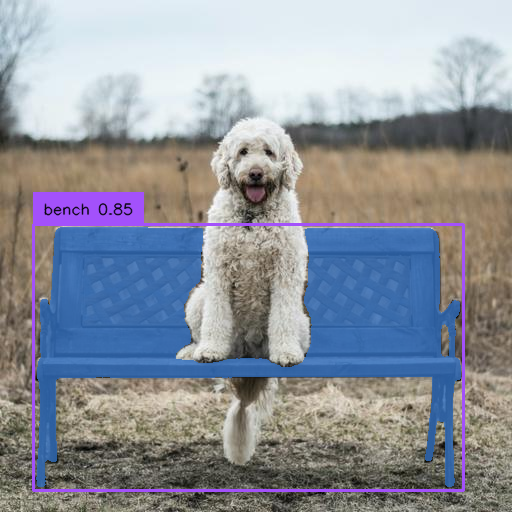

In [12]:
segmented_frame_masks = segment(image_source, sam_predictor, boxes=detected_boxes)
annotated_frame_with_mask = draw_mask(segmented_frame_masks[0][0], annotated_frame)
Image.fromarray(annotated_frame_with_mask)

## Stable Diffusion for inpainting

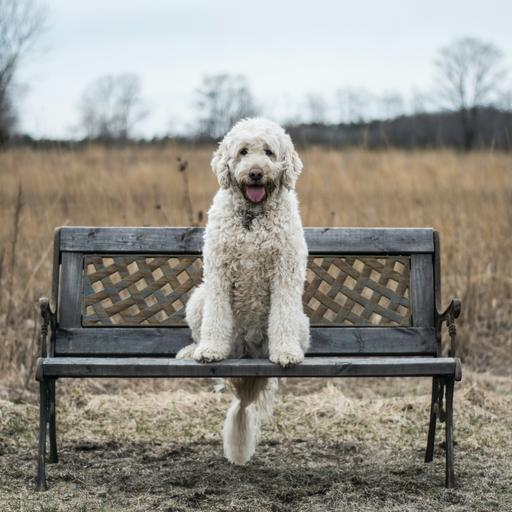

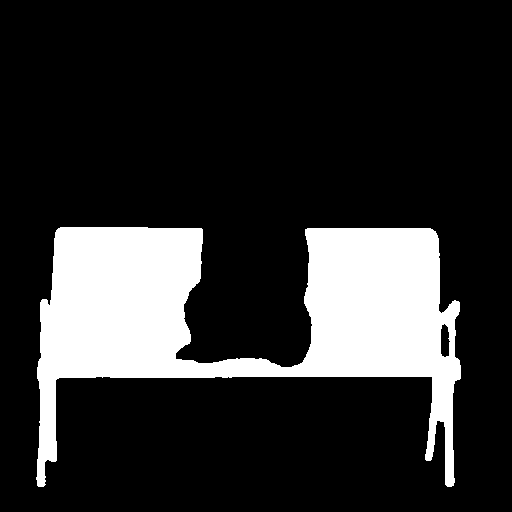

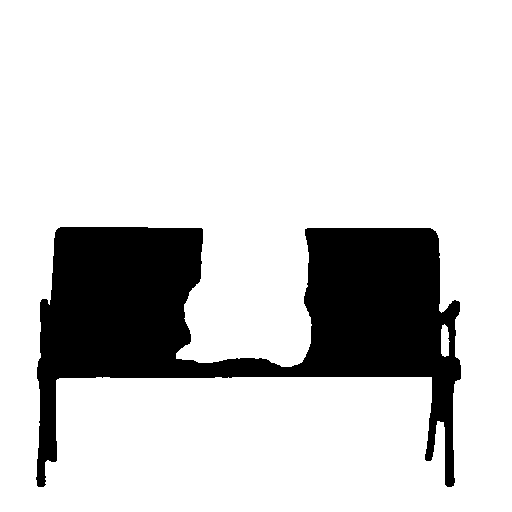

In [13]:
# create mask images
mask = segmented_frame_masks[0][0].cpu().numpy()
inverted_mask = ((1 - mask) * 255).astype(np.uint8)


image_source_pil = Image.fromarray(image_source)
image_mask_pil = Image.fromarray(mask)
inverted_image_mask_pil = Image.fromarray(inverted_mask)


display(*[image_source_pil, image_mask_pil, inverted_image_mask_pil])

In [14]:
def generate_image(image, mask, prompt, negative_prompt, pipe, seed):
  # resize for inpainting
  w, h = image.size
  in_image = image.resize((512, 512))
  in_mask = mask.resize((512, 512))

  generator = torch.Generator(device).manual_seed(seed)

  result = pipe(image=in_image, mask_image=in_mask, prompt=prompt, negative_prompt=negative_prompt, generator=generator)
  result = result.images[0]

  return result.resize((w, h))

  0%|          | 0/50 [00:00<?, ?it/s]

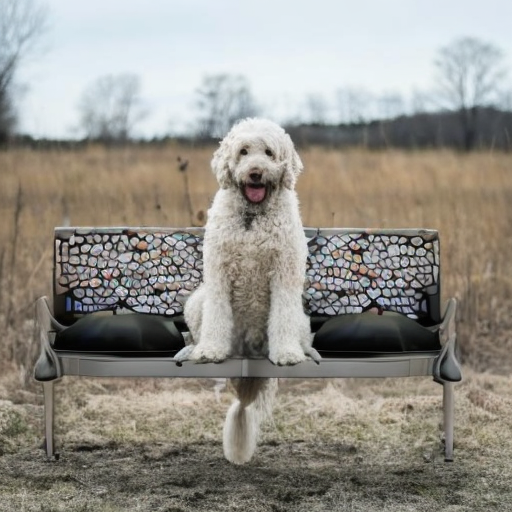

In [15]:
prompt="A sofa, high quality, detailed, cyberpunk, futuristic, with a lot of details, and a lot of colors."
negative_prompt="low resolution, ugly"
seed = 32 # for reproducibility

generated_image = generate_image(image=image_source_pil, mask=image_mask_pil, prompt=prompt, negative_prompt=negative_prompt, pipe=sd_pipe, seed=seed)
generated_image

  0%|          | 0/50 [00:00<?, ?it/s]

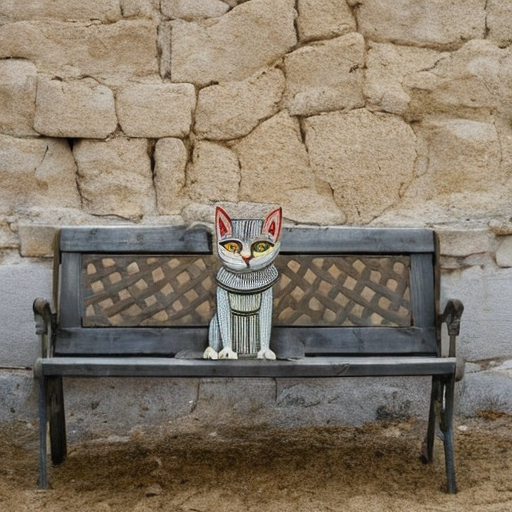

In [23]:
prompt="empty bench, in ancient egypt, royal cat from ancient egypt"
negative_prompt="low resolution, ugly"
seed = 32 # for reproducibility

generated_image = generate_image(image_source_pil, inverted_image_mask_pil, prompt, negative_prompt, sd_pipe, seed)
generated_image